# <center>Spreading disease through the air</center> 
#### <center>EE-558 - _A Network Tour of Data Science_ - Final Project</center>

***

## Students

* Team: `8`
* Students: `Matyas Lustig, Aurélien Pomini, David Salathé, Justine Weber`
* Dataset: `Flight Routes`

## Motivation

Imagine a new disease emerges and spreads quickly over our globalized world. Or that someone does it on purpose as a form of an attack. Can we predict how it propagates via the interconnected airports around the globe? We try to answer that question with the help of signal processing and spectral decomposition approach as our aim is not to find an optimal solution by copying papers already showing great result (by using SIR, Susceptible-infected-removed, models for example). In this work we present you a nice way to graphically simulate a disease attack and we attempt to find the most effective way to infect most airports. <br>

We will go through several steps :
1. [Building the network](#Building-the-network)<br>
1.1 [Load data](#load)<br>
1.2 [Create the adjacency matrix](#adjacency) <br>
1.3 [Cleaning and Pre-processing](#clean)<br>
1.4 [Symmetry and self-loops](#symmetry) <br>
1.5 [Extracting largest connected component](#giant-comp) <br>

2. [Data pre-processing](#Data-pre-processing)
3. [Plotting tools](#Plot-tools)
4. [Insights on the data and network](#Insights-on-the-data-and-network)
5. [Spreading diseases](#Spread) <br>
5.1 [Spectral clustering](#spectral-cluster)<br>
5.2 [Graph signal processing](#graph-signal-proc)<br>
5.3 [Top five highest degree](#top5)<br>
5.4 [Brute Force](#brute-force)<br>

This notebook should be read together with **the corresponding report** in order to understand in detail why and how we have done everything. Some part of the report have been reproduced in this notebook in order to help you understand our goal and the theory behind what we have done.

If you want to run it yourself, be aware that it might take around 5 to 10 minutes (6min 45s in average with an i7-6500U 2.5 GHz processor). You will also need two databases that can be found [here](https://openflights.org/data.html) (you will need airports.dat and routes.dat).

***

## Imports

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import scipy
from scipy import sparse

from mpl_toolkits.basemap import Basemap
# if you don't have it installed run : conda install -c anaconda basemap

import sys

In [6]:
# Plotting tools : for adapting colorbar size
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ML methods for k-means clustering
from sklearn.cluster import KMeans

---
<a id='Building-the-network'></a>
## <center> BUILDING THE NETWORK </center>
---

### Description 
The network we have build for this project is structured accordingly: the nodes of our graph are airports and there is an edge between two nodes, if there is a flight route between their corresponding airports. For the purpose of this project, we have used two datasets from [**OpenFlight**](https://openflights.org/data.html).

The first one - _routes_ - has been used to build the graph in the most intuitive way: each entry of this dataset describes a flight route, defined by its airline, a source airport, a destination airport, and some others (cf. code below). We have therefore used each entry of the dataset as an edge in our graph. <br>
The second dataset - _airports_ - has been used in order to get features and labels on the nodes of our graph. Each entry of this dataset describes an airport through twelve features. Five of them have been useful for our project : _name, city, IATA, latitude, longitude_. <br>

An insight of the airports table is given below.

### Tool functions

In [7]:
def unweight(matrix) :
    assert(isinstance(matrix, np.ndarray))
    assert(matrix.shape[0] == matrix.shape[1])
    uw = matrix.copy()
    uw[uw>0] = 1
    return uw

In [8]:
def features_from_IATA(features, active):
    """ Returns dataset of targeted airports,
    Given the list of IATA we want
    
    features : dataframe containing a columns 'IATA'
    active : dictionnary where the values are 'IATA' codes
    """
    select_feat = features[features['IATA'].isin(active.values())]
    select_feat = select_feat.reset_index(drop=True)
    
    return select_feat

<a id='load'></a>
### Load data
In order to build the graph, we have **only kept the airports which appear both in the _airports_ and in the _routes_ datasets**. In fact, some entries in the _routes_ dataset have a IATA code as source or destination airport which is not referenced in the _airports_ dataset. We decided to discard these because we don't have any information on the nodes connected by these edges. Conversely, some airports from the _airports_ dataset were not referenced in the _routes_ one. Adding these nodes to our graph would have added a lot of isolated nodes, which we didn't want to exploit in our project. Therefore we have also decided to discard these. In total, there are 7184 entries in the _airports_ dataset, and 3334 distinct airports (either source or destination or both) in the _routes_ dataset. After extracting the _intersection_ between the two datasets by inner join operation, we got 3186 airports, which we call "active" airports.

In [9]:
# Load airports dataset to get the features for each node
airports_ds = pd.read_csv('data/airports.dat', header = None, encoding='utf-8', names = ["Airport ID", "Name"
                                                                                         , "City", "Country", 
                              "IATA", "ICAO", "Latitude", "Longitude", "Altitude", 
                              "Timezone", "DST", "Tz db time zone", "Type", "Source"])

# Load routes dataset to get the nodes and edges that we will use to create the network
routes = pd.read_csv('data/routes.dat', sep=',', encoding='utf-8', engine='python', 
                     names = ["Airline", "Airline_ID", "Source_airport", "Source_airport_ID", 
                              "Destination_airport", "Destination_airport_ID", "Codeshare", "Stops", "Equipment"]
                     , na_values=['\\N'])

# Take all airports ID which are listed in the routes dataset, either as destination or as source
airports = pd.concat([routes["Source_airport_ID"],routes["Destination_airport_ID"]], axis=0)
airports = airports.drop_duplicates()

# Take lines of the airport dataset, corresponding to the above airports (ie. listed in routes)
features = airports_ds[airports_ds['Airport ID'].isin(airports)]

features = features.set_index(pd.Series(range(len(features))))
features = features.assign(newidx=pd.Series(range(len(features))).values)


print("Number of airports in the airports.dat file:", len(airports_ds))
print("Number of \"active\" airports in the routes.dat file:", len(features))
features.head(4)

Number of airports in the airports.dat file: 7184
Number of "active" airports in the routes.dat file: 3186


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz db time zone,Type,Source,newidx
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports,0
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports,1
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports,2
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports,3


<a id='adjacency'></a>
### Create the adjacency matrix
Our graph is described by an adjacency matrix. The latter is built by iterating through the entries of the routes which we have kept (cf.above).

The array active, which is further converted into a dictionary, is useful for **keeping track of the indices in the feature table of the nodes we keep**. Through the notebook, we will discard or select som particular nodes and in order to visualize and interpret our results, we need to keep in memory which airports we have kept.

As we have explained above, in the _routes_ dataset the entries have a source airport, a destination airport and an airline. Therefore the same connection from a source and destination airport is sometimes represented several times in the dataset, if several different airlines take it. We have used this to **add weights to our edges**.

We have constructed two adjacency matrices : a **weighted** one and an **unweighted** one. Both of them can be useful for different tasks. The unweighted one is useful for example to know how many airports are connected to a particular one, whereas the weighted one contains more information on the traffic between the airports.

In [10]:
# Create dataframe of source and destination IATA for each route
idx_IATA = features[['IATA', 'newidx']]
routes_srcdest = routes[['Source_airport', 'Destination_airport']]

# Left join because we preserve the airports from routes, even if you don't have features on them
idx_src = routes_srcdest.merge(right=idx_IATA, how='left', left_on='Source_airport', right_on='IATA')
idx_src_dest = idx_src.merge(right=idx_IATA, how='left', left_on='Destination_airport', right_on='IATA',
                             suffixes=['_src', '_dest']).drop(columns=["IATA_src", "IATA_dest"])

In [11]:
# Build the general adjacency matrix
n_nodes = len(features)

active_l = ["" for x in range(n_nodes)]

adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
adjacency_uw = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in idx_src_dest.iterrows():

    if pd.isnull(row.newidx_src) or pd.isnull(row.newidx_dest):
        continue
    i, j = int(row.newidx_src), int(row.newidx_dest)
    
    active_l[i] = row.Source_airport
    active_l[j] = row.Destination_airport
    
    adjacency_uw[i, j] = 1
    
    adjacency[i, j] = adjacency[i, j] + 1

#adjacency.max()
active = np.asarray(active_l)

<a id='clean'></a>
### Cleaning and Pre-processing
We noticed that our network still comprises **seven isolated nodes** (see below). These nodes are present in our network because their are referenced in both datasets, but they are isolated because according to the _routes_ dataset, they are only connected to other airports which are not referenced in the _airports_ dataset and therefore were discarded. Therefore we have removed these airports from our network.

In order to remove them from our network we need to remove them from the feature table and delete the corresponding rows and columns from the adjacency matrix.

In [12]:
a = adjacency.sum(axis=1)
b = adjacency.sum(axis=0)

zero_in = np.argwhere(a==0)
zero_out = np.argwhere(b==0)

print("The following values are indices of airports which are connected to nothing :")
no_connection = []

for value in zero_in :
    if np.isin(value[0],zero_out):
        no_connection.append(value[0])

# Check : the table no_connection should exactly contain the elements which 
# are represented with an empty string in active_l 
assert(no_connection == [i for i, val in enumerate(active_l) if val == ""]) 
   
print(no_connection)
print("\nTheses airports are the following:")
print(features.loc[features['newidx'].isin(no_connection), ['IATA', 'City', 'Country']])

The following values are indices of airports which are connected to nothing :
[1522, 1523, 2643, 3027, 3029, 3040, 3088]

Theses airports are the following:
     IATA              City         Country
1522  RJA       Rajahmundry           India
1523  TIR          Tirupeti           India
2643  LPS             Lopez   United States
3027  AKI             Akiak   United States
3029  TKJ               Tok   United States
3040  SPB  Charlotte Amalie  Virgin Islands
3088  AGM      Angmagssalik       Greenland


In [13]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DROPS COLUMNS EACH TIME
features = features.drop(features.index[no_connection])
features = features.set_index(pd.Series(range(len(features))))
features = features.assign(newidx=pd.Series(range(len(features))).values)

In [14]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DELETES ROWS & COLUMNS EACH TIME
adjacency = np.delete(adjacency, no_connection, 0)
adjacency = np.delete(adjacency, no_connection, 1)
adjacency_uw = np.delete(adjacency_uw, no_connection, 0)
adjacency_uw = np.delete(adjacency_uw, no_connection, 1)

In [15]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DELETES ELEMENTS EACH TIME
active = np.delete(active, no_connection)

In [16]:
active = dict(enumerate(active))

<a id='symmetry'></a>
### Symmetry and self-loops
We have noticed that one element on the diagonal of our adjacency matrix was non-zero. This corresponds to having a **self-loop** in the graph, and comes from the fact that one entry in the _routes_ dataset has the same airport both as a source and destination. We have considered this as an anomaly, as it doesn't make sense to have a self-loop for a flight route network. Therefore we have set this diagonal element to zero. <br> 

The graph we use in this project is **symmetric and weighted**. Originally, our data describes directed edges, with a source and a destination but we have decided to simplify our graph: each edge of our network represents a flight route, which can be taken both ways.

In summary, the edges of our graph are undirected, and the weight of each edge represents the number of airlines taking the corresponding route. Note that if an airline takes the route in both ways, it is counted twice. 


In [17]:
# Set diagonals to zero to remove self loops
adjacency[np.diag_indices_from(adjacency)] = 0
adjacency_uw[np.diag_indices_from(adjacency_uw)] = 0

In [18]:
# Build the symmetric matrices (weighted and unweighted)
adjacency_sym = adjacency + adjacency.T
adjacency_uw_sym = unweight(adjacency_sym)

In [19]:
# the adjacency matrix we use for the project : symmetric and weighted
adj = adjacency_sym

<a id='giant-comp'></a>
### Extracting largest connected component
The network we got so far is composed of **seven connected components**.
As the goal of this project is to get an insight on how a disease can spread across our network, is doesn't make sense to keep several components which are not connected at all. Moreover, the largest connected component of our network is composed of 3154 nodes. This means most of our graph is in this component and the other components consists in 10, 4, 3 or 2 nodes. Our largest connected component is therefore a **giant component** and we have decided to keep it as our final network.

In the cell below, we extract this giant component. This is what we will use for the rest of the project.

In [23]:
# Create graph in networkx
G = nx.from_numpy_matrix(adj)

nx.set_node_attributes(G, active, "IATA")

# Extract largest connected component
all_comp = nx.connected_component_subgraphs(G)

# all_comp_nodes is the list of nodes indices for each component
all_comp_nodes = nx.connected_components(G)

# create a list of indices of nodes which are not in the largest component
aside_nodes = []
for nodes in all_comp_nodes:
    #print(len(nodes))
    if(len(nodes)!=3154):
        for node in nodes :
            aside_nodes.append(node)

Gc = max(all_comp, key=len)
active_c = nx.get_node_attributes(Gc,"IATA")

# Take the corresponding adjacency matrix
adj_c = np.array(nx.to_numpy_matrix(Gc))
adj_uw_c = unweight(adj_c)
n_nodes_c = nx.number_of_nodes(Gc)

---
<a id='Data-pre-processing'></a>
## <center> DATA PRE-PROCESSING </center>
---

### Sample part of the graph for interesting insights
We have noticed than by filtering the network, i.e. keeping only some nodes given a characteristic and a threshold, we were able to highlight some interesting insights, which were hidden when given the whole network.
In this section we build a "filtered" graphs, by keeping the nodes which have a degree lower / higher than a given threshold.<br>
This will be used further in the project.

Note that here we use the **unweighted** adjacency matrix, i.e. we only take into account the **number of other airports** to which an airport is connected to define it as very connected or poorly connected, and not the number of flights per route.

In [28]:
def sample_by_degree(adj = adj_uw_c, threshold = 0, way='gt') :
    degrees = np.sum(adj, axis = 1)
    if way == 'gt' :
        select_idx = np.where(degrees >= threshold)[0]
        new_adj = np.delete(adj, np.where(degrees < threshold), 0)
        new_adj = np.delete(new_adj.T, np.where(degrees < threshold), 0)
    elif way == 'lt' :
        select_idx = np.where(degrees <= threshold)[0]
        new_adj = np.delete(adj, np.where(degrees > threshold),0)
        new_adj = np.delete(new_adj.T, np.where(degrees > threshold), 0)
    elif way == 'exact' :
        select_idx = np.where(degrees == threshold)[0]
        new_adj = np.delete(adj, np.where(degrees != threshold),0)
        new_adj = np.delete(new_adj.T, np.where(degrees != threshold), 0)
    else :
        raise ValueError("'way' parameter should be either gt or lt or exact," 
                         + "respectively for greater than, less than, or exactly the threshold")
    
    airports = features.index[select_idx].values
    dict_airports = {}
    for i in airports :
        i = int(i)
        dict_airports[i] = features.iloc[i]['IATA']
    
    new_deg = np.sum(new_adj, axis = 1)
    print("Size of extracted adjacency matrix: ",new_adj.shape)
    return new_adj, new_deg, dict_airports

#### Very connected (deg >= 20)

In [29]:
adj_gt20, deg_gt20, airports_gt20 = sample_by_degree(threshold = 20, way = 'gt')

Size of extracted adjacency matrix:  (451, 451)


#### Very very connected (deg >= 170)

In [30]:
adj_gt170, deg_gt170, airports_gt170 = sample_by_degree(threshold = 170, way = 'gt')

Size of extracted adjacency matrix:  (12, 12)


#### Very not connected (deg <= 10)

In [31]:
adj_lt1, deg_lt1,airports_lt1  = sample_by_degree(threshold = 1, way = 'lt')

Size of extracted adjacency matrix:  (697, 697)


---
<a id='Plot-tools'></a>
## <center> PLOTTING TOOLS </center>
---

In order to plot our signals of maps and have good data visualization, we have used the [BaseMap library](https://matplotlib.org/basemap/api/basemap_api.html#mpl_toolkits.basemap.Basemap.contour).

In [32]:
# Saving all the latitudes and longitudes in matrices
nb_airpt = n_nodes_c

features_c = features_from_IATA(features, active_c)

lats_airpt = np.zeros(nb_airpt)
lons_airpt = np.zeros(nb_airpt)

for idx, row in features_c.iterrows():
    lats_airpt[idx] = row['Latitude']
    lons_airpt[idx] = row['Longitude']

In [33]:
def plot_map(signal, scale_size=1, alpha_=0.6, colors='Reds', edges=False, adapt_size=True, legend="", 
            nodes_size_legend=False, nodes_size_legend_array=[], max_size=200, base_size=1):
    """
     Main method to plot nodes on a map.
    """ 
    assert(len(signal)==len(features_c))
           
    # Plot of the mondial map
    plt.figure(figsize=(20,20))
    mymap = Basemap(projection='cyl')

    mymap.drawmapboundary(fill_color='silver')
    mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
    mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
    mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


    x_lons, y_lats = mymap(lons_airpt, lats_airpt)
    
    # adapt size of the nodes depending on signal values
    if adapt_size :
        size = signal
    else :
        size = 1
        
    size = np.minimum(size*scale_size+base_size, max_size)
    
    mymap.scatter(x_lons, y_lats, marker='o', s=size, zorder=5, alpha=alpha_, 
                  c = signal, cmap=colors)

    # plot edges
    if edges :
        for i in range(nb_airpt):
            for j in range(i):
                if (adj_c[i,j]>0) :
                    mymap.plot([x_lons[i], x_lons[j]], [y_lats[i], y_lats[j]], linewidth=1, color='w', 
                               linestyle='solid', alpha = 0.1)
    
    # create colorbar and legend
    plt.colorbar(label=legend,fraction=0.025, pad=0.04)
    
    if nodes_size_legend :
        if len(nodes_size_legend_array) == 0:
            raise ValueError("Parameters node_size_legend and node_size_legend_array must match." +
                             " If node_size_legend is set True, then node_size_legend_array must be non empty")
            return
        else :
            for a in nodes_size_legend_array:
                plt.scatter([], [], c='k', alpha=0.5, s=a, label= str(a))
            
            plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left')
    else :
        if len(nodes_size_legend_array) != 0:
            print("Value of parameter nodes_size_legend is set at False by default." +
                  " Parameter node_size_legend_array is therefore ignored.")
    

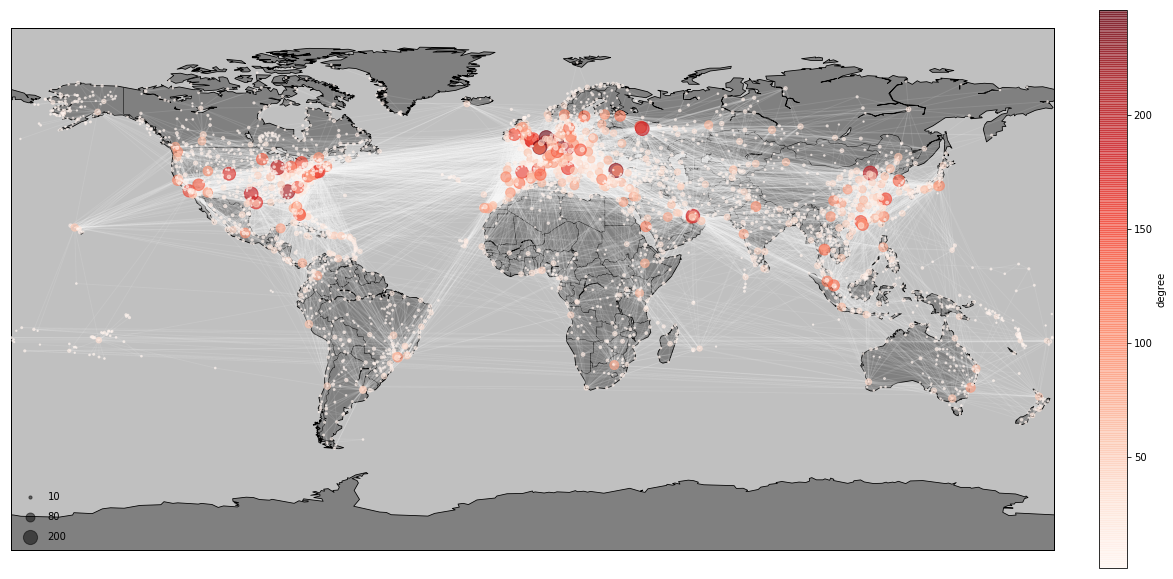

In [34]:
# CAREFULL, THIS CELL TAKES SOME TIME TO RUN (~5 minutes with an i7 processor)
# Plot of the mondial map with all edges
connectivity = np.sum(adj_uw_c, axis = 1)

plot_map(connectivity, edges=True, nodes_size_legend=True, 
         nodes_size_legend_array=[10, 80, 200], legend = "degree")

---
<a id='Insights-on-the-data-and-network'></a>
## <center> INSIGHTS ON THE DATA AND NETWORK </center>
---

### Motivation
Once our network had been built, we have started by **plotting several labels** which we have created from the features of the nodes. This has enables us to get a hand on our data, and better understand how to process it for the following of the project. Below, are shown two labels which we have created : north/south and continents.

These following cells create and display some interesting labels to be studied in further research. However, we will **not use them to answer our main question** (spreading disease).

In [35]:
def continent_convert(c):
    '''Tool function which returns a number given a letter as parameter, 
    which should be one of :
        E (Europe), 
        A (US/Canada), 
        S (South America), 
        O (Australia), 
        Z (New Zealand), 
        N (None) or 
        U (Unknown)
    This is useful for having numbered values for plotting the signal of 
    continents, created below from the features of the graph.'''
    
    switcher = {
        'E' : 1,
        'A': 2,
        'S': 3,
        'O': 4,
        'Z': 5,
        'N': 6,
        'U': 0
    } 
    return switcher.get(c, "Invalid label")

In [36]:
# Creating both labels
north_south = features_c["Latitude"].apply(lambda x: -1 if x < 0 else 1)
continent = features_c["DST"].apply(continent_convert)

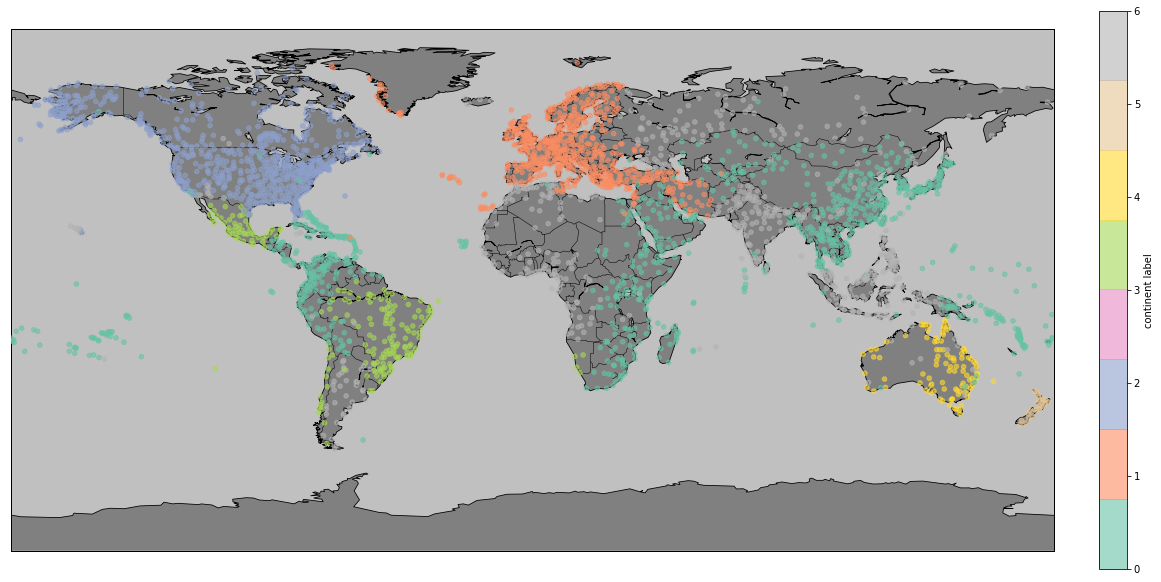

In [40]:
# Plotting the continent signal
plot_map(continent, colors='Set2', scale_size=20, adapt_size=False, legend="continent label")

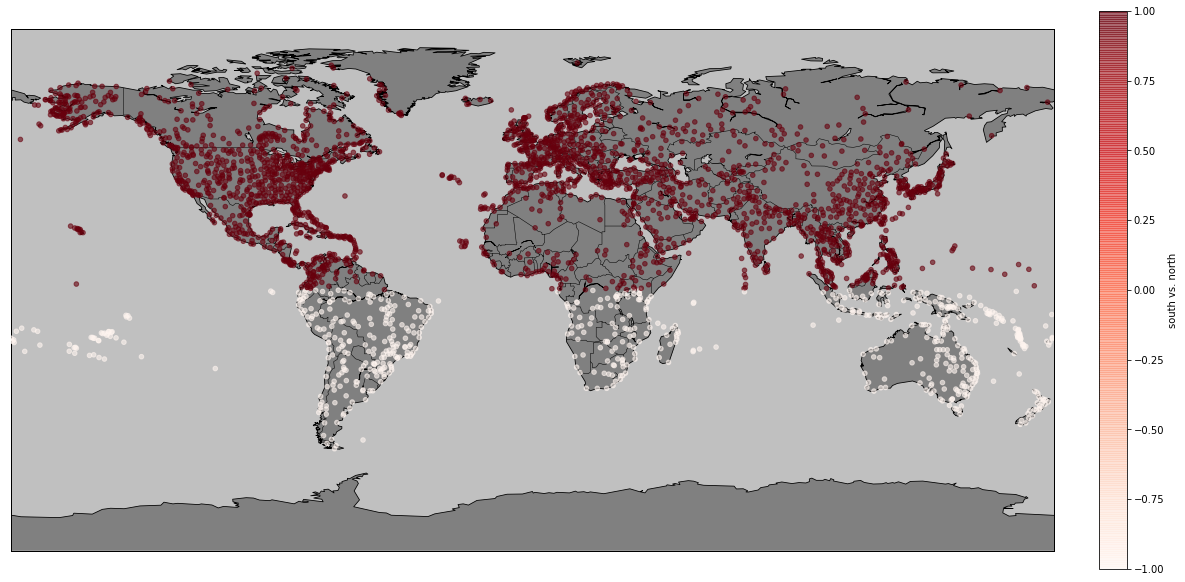

In [42]:
# Plotting the north/south signal
plot_map(north_south, colors='Reds', scale_size=20, adapt_size=False, legend="south vs. north")

---
<a id='Spread'></a>
## <center> SPREADING DISEASES </center>
---

In this section, we present and compare the different methods which we have tested and improved, in order to model the spread of diseases through the world's flight routes.

<a id='spectral-cluster'></a>
### Spectral clustering

In [43]:
def spectral_clustering(adjacency, k, d):
    """
    Main method to cluster set of nodes using Laplacian Eigenmaps (eigendecomposition)
    adjacency: entries of airports choen to be plot
    k: number of cluster desired
    d: embedding of adjacency matrix
    
    @return: Z, result of clustering of each nodes
    """
    
    laplacian_c = sparse.csgraph.laplacian(adjacency, normed=True)
    e, U = scipy.linalg.eigh(laplacian_c)
    clusters = k
    k_eig_val, k_eig_vect = scipy.sparse.linalg.eigsh(laplacian_c, k=d, which='SM')

    diag = np.diag(laplacian_c)
    for i in range(d):
        k_eig_vect[:, i] /= diag
    inter = KMeans(n_clusters=clusters, random_state=0).fit_predict(k_eig_vect)
    Z = np.array(inter)
    print("0's:", np.count_nonzero(Z==0) )
    print("1's:", np.count_nonzero(Z==1))
    print("2's:", np.count_nonzero(Z==2) )
    return Z

In [44]:
def spectral_plot(airports, adjacency, k=3, d=10, features=features, title="Spectral Clustering"):
    """
    airports: dictionary of airports corresponding to those on the chosen adjacency
    adjacency: entries of airports chosen to be plot
    k: number of clusters desired
    d: embedding of adjacency matrix (you can keep it low, features are extremely dependent)
    features: basic database having lattitude, longitude, etc
    title: title of plot.
    
    @return: Z, result of clustering of each nodes
    """
    Z = spectral_clustering(adjacency, k, d)
    nb_airpt = len(airports)
    features_c = features_from_IATA(features, airports)
    lats_airpt = np.zeros(nb_airpt)
    lons_airpt = np.zeros(nb_airpt)


    for idx, row in features_c.iterrows():
        lats_airpt[idx] = row['Latitude']
        lons_airpt[idx] = row['Longitude']
    
    # Plot of the mondial map
    fig = plt.figure(figsize=(20, 20))
    mymap = Basemap(projection='cyl')

    mymap.drawmapboundary(fill_color='silver')
    mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
    mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
    mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


    x_lons, y_lats = mymap(lons_airpt, lats_airpt)



    mymap.scatter(x_lons, y_lats,latlon=True, marker='o', s=30, zorder=5, alpha=0.6, 
                  c=Z, cmap='brg')

    plt.colorbar(label=r'${\rm degree}$',fraction=0.025, pad=0.04)
    plt.title(title)
    return Z



0's: 3088
1's: 45
2's: 21


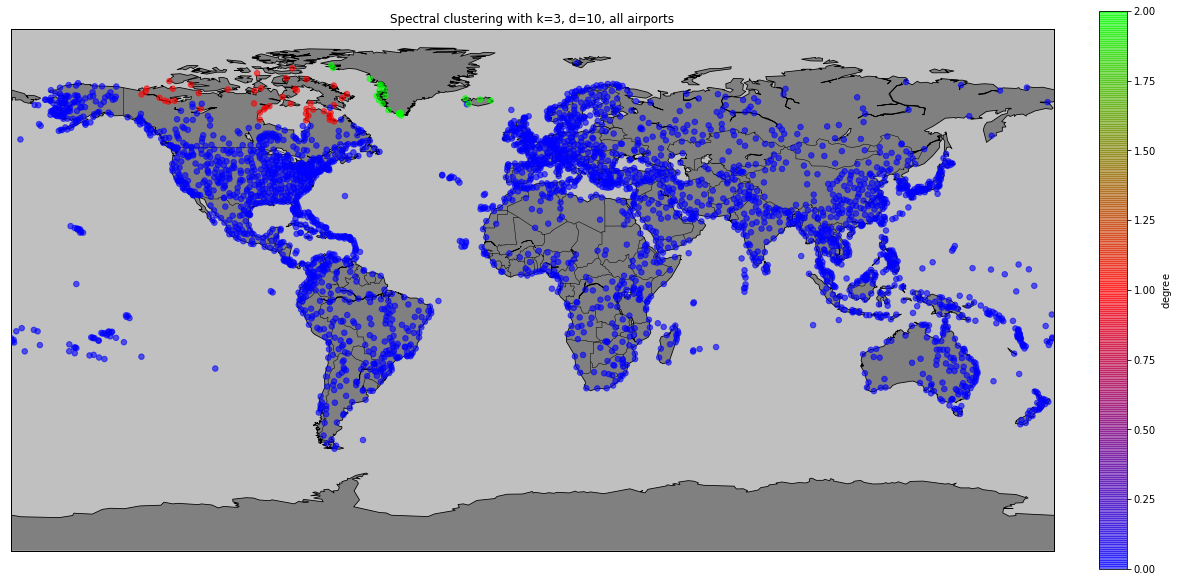

In [45]:
# Raw spectral plot 
Z = spectral_plot(active_c, adj_c, title="Spectral clustering with k=3, d=10, all airports")

0's: 2656
1's: 22
2's: 58


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

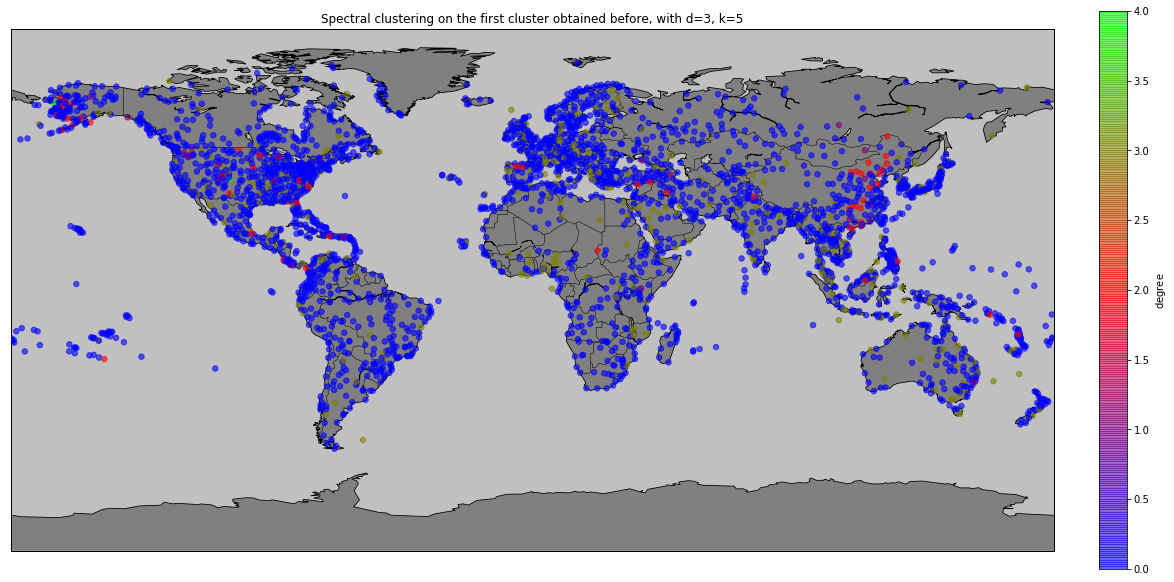

In [46]:
# Keeping first cluster only and doing it again:
def reconstruct_connected_graph(adj, select_idx) :
    ''' TODO DESCRIPTION
    '''
    new_adj = adj[select_idx]
    new_adj = new_adj[:, select_idx]
    
    # Extracting Largest connected component

    # Create graph in networkx
    G = nx.from_numpy_matrix(new_adj)

    nx.set_node_attributes(G, active, "IATA")
    #nx.set_node_attributes(G, types_dict, "type")

    # Extract largest connected component
    all_comp = nx.connected_component_subgraphs(G)

    # all_comp_nodes is the list of nodes indices for each component
    all_comp_nodes = nx.connected_components(G)


    Gc = max(all_comp, key=len)
    dict_airports = nx.get_node_attributes(Gc,"IATA")

    # Take the corresponding adjacency matrix
    new_adj = np.array(nx.to_numpy_matrix(Gc))
    
    new_deg = np.sum(new_adj, axis = 1)
    return new_adj, new_deg, dict_airports

first_cluster_adj, _, first_cluster_airports = reconstruct_connected_graph(adj_c, np.where(Z==0)[0])
spectral_plot(first_cluster_airports, first_cluster_adj, d=3, k=5, 
              title="Spectral clustering on the first cluster obtained before, with d=3, k=5")

Size of extracted adjacency matrix:  (612, 612)
0's: 155
1's: 203
2's: 157


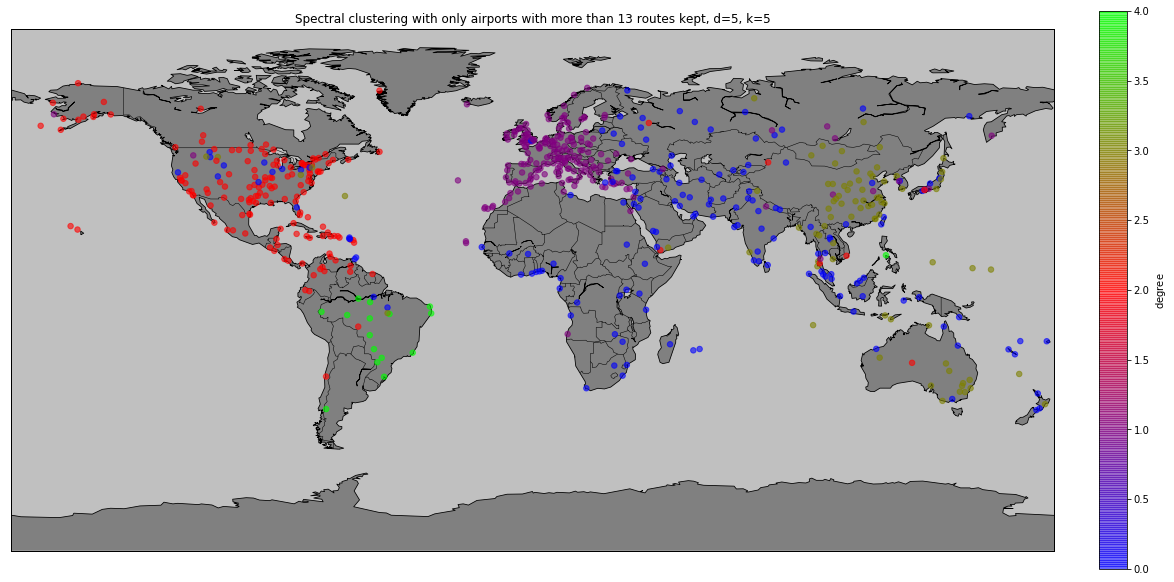

In [48]:
# Spectral plot after removing the least connected nodes (degree < 13) 
# (i.e. selecting data as explained in section data preprocessing)

adj_gt13, deg_gt13, airports_gt13 = sample_by_degree(threshold = 13, way = 'gt')

Z = spectral_plot(airports_gt13, adj_gt13, d=5, k=5, 
                 title="Spectral clustering with only airports with more than 13 routes kept, d=5, k=5")

<a id='graph-signal-proc'></a>
### Graph Signal Processing

In [50]:
# Compute Laplacian
laplacian_c = sparse.csgraph.laplacian(adj_c, normed=True)
e, U = scipy.linalg.eigh(laplacian_c)

In [51]:
# METHODS IMPLEMENTED DURING MILESTONE 4
def GFT(x):
    return U.T.dot(x)

def iGFT(x):
    return U.dot(x)


def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    return np.diag(np.linalg.inv(np.identity(n_nodes_c) + t*np.diag(e)))

def rectangle_kernel(e, l_min, l_max):
    f = np.vectorize(lambda x: 1.0 if x >= l_min and x <= l_max else 0.0)
    return f(e)

def graph_filter(x, kernel, **kwargs):    
    return iGFT(GFT(x) * kernel(e=e, **kwargs))

###### THE IMPORTANT PARAMETER. 
#Notice that if you set it to t_heat=10, then Heathrow beats Amsterdam for example.
t_heat = 0.15

# Optional
t_inv = 0.35
lmin = 0.0
lmax = 1.1

def metric_propag(signal, threshold):
    """
    Our main metric. Return the number of nodes having a value higher than the threshold.
    """
    return np.count_nonzero(signal[signal>threshold])


def kernel_map(init_signal, scale_size = 100, adapt_size=True, t_heat=t_heat, t_inv=t_inv, lmin=lmin,
               lmax=lmax, kernels="all", metric_threshold=300, legend="", base_size=1, max_size=100) :
    """
    This method takes a signal and a kernel as input and renders a mondial plot of the propagation of the signal.
    """
    
    if kernels == "all" or kernels == "heat":
        print("----------------HEAT----------------")
        heat = graph_filter(init_signal, heat_kernel, t=t_heat)
                
        print("Metric :", metric_propag(heat, metric_threshold))

        plot_map(heat, scale_size = scale_size, adapt_size=adapt_size, legend=legend, 
                 base_size=base_size, max_size=max_size)
        print()

    if kernels == "all" or kernels == "rectangle":
        print("--------------RECTANGLE--------------")
        rectangle = graph_filter(init_signal, rectangle_kernel, l_min=lmin, l_max = lmax)
        
        print("Metric :", metric_propag(rectangle, metric_threshold))
        
        plot_map(rectangle, scale_size = scale_size, adapt_size=adapt_size, legend=legend, 
                 base_size=base_size, max_size=max_size)

<a id='top5'></a>
### Top 5 highest degree

----------------HEAT----------------
Metric : 493



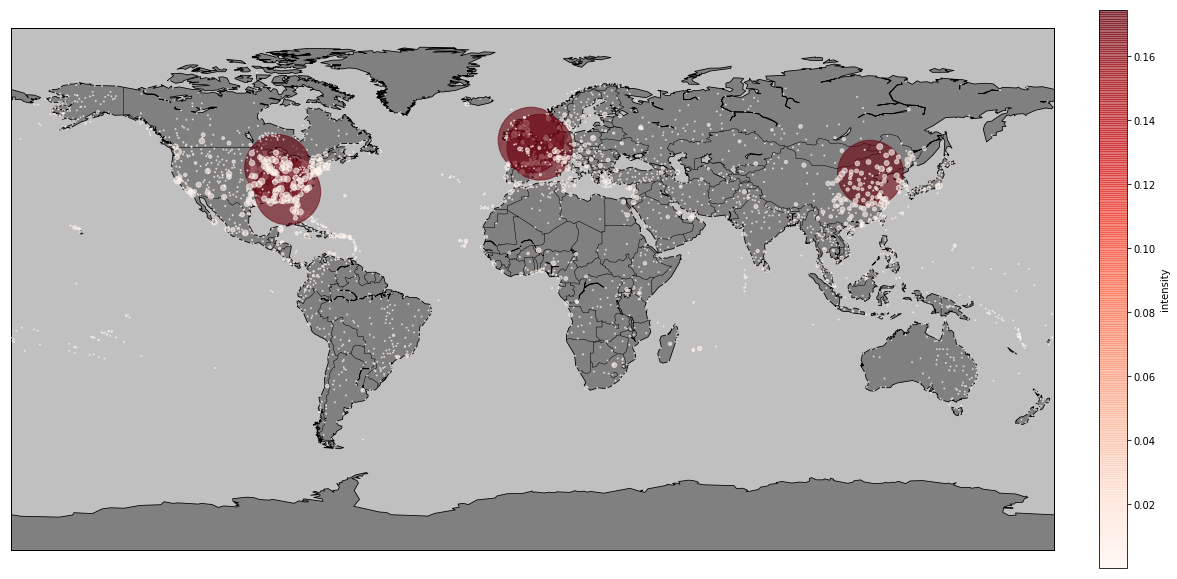

In [52]:
# Find top 5 highest degree nodes and construct a signal with thoses nodes being the entry
dirac = np.zeros(U.shape[0])
degrees = np.sum(adj_c, axis=0)
top5 = degrees.argsort()[-5:][::-1]

for i in range(5):    
    dirac[top5[i]]=1/top5.shape[0]

# Propagate the pseudo-dirac onto the graph using a heat kernel
heat = graph_filter(dirac, heat_kernel, t=t_heat)
kernel_map(dirac, scale_size= 25000, kernels="heat", metric_threshold=1/(3154), legend="intensity",
          base_size=1, max_size=10000000)

In [53]:
# Printing the 5 winners
for i in top5:
    print(features_c.set_index("Name", drop=True).iloc[i][["City", "Country", "IATA"]])
    print()

City             Atlanta
Country    United States
IATA                 ATL
Name: Hartsfield Jackson Atlanta International Airport, dtype: object

City             Chicago
Country    United States
IATA                 ORD
Name: Chicago O'Hare International Airport, dtype: object

City               London
Country    United Kingdom
IATA                  LHR
Name: London Heathrow Airport, dtype: object

City        Paris
Country    France
IATA          CDG
Name: Charles de Gaulle International Airport, dtype: object

City       Beijing
Country      China
IATA           PEK
Name: Beijing Capital International Airport, dtype: object



<a id='brute-force'></a>

### Bruteforce

This bruteforce approach is guaranteed to find the best solution according to our metric.
However, exploring all the possibilities of sources is too slow. Since with k=1 it takes almost one minute on a casual computer, it is not reasonable to use this algorithm with k > 1.

In [54]:
def bruteforce(k, kernel, **kwargs):
    """
    Method to bruteforce the best combination of k airports.
    @parameters:
    k: the number of selected airports
    kernel: the kernel used to spread the signal
    kwargs: optional additional parameters
    @return: pair of best airports, the pseudo-dirac signal
    """
    indexes = list(range(k))

    def plus_one(indexes):

        for i in range(k):

            current = k-1-i
            indexes[current] += 1
            if(indexes[current] >= n_nodes_c):
                indexes[current] = 0
            else:
                return        

    def valid(indexes):
        return len(indexes) == len(set(indexes))

    best_score = 0
    best_indexes = None
    best_dirac = None
    

    n_itr = 0
    while n_itr == 0 or sum(indexes) != 0:
        dirac = np.zeros(n_nodes_c)
        for i in indexes:
            dirac[i] = 1/k

        filtered = graph_filter(dirac, kernel, **kwargs)
        score = metric_propag(filtered, threshold=1/n_nodes_c)

        if score > best_score:
            best_score = score
            best_indexes = indexes.copy()
            best_dirac = dirac.copy()
        
        plus_one(indexes)
        n_itr+=1     
        
    return best_indexes, best_dirac

## Spectral clustering approach



We will use spectral clustering to find the k best sources.
The idea is to cut graph into k clusters, and find the optimal source for each cluster individually.

In other words, we will suggest that there are good solutions for this problem where each source is in a different cluster. While this solution might not be optimal, this constraint reduces drastically the complexity of the problem, allowing a polynomial computing time. 

0's: 155
1's: 203
2's: 157
----------------HEAT----------------
Metric : 566



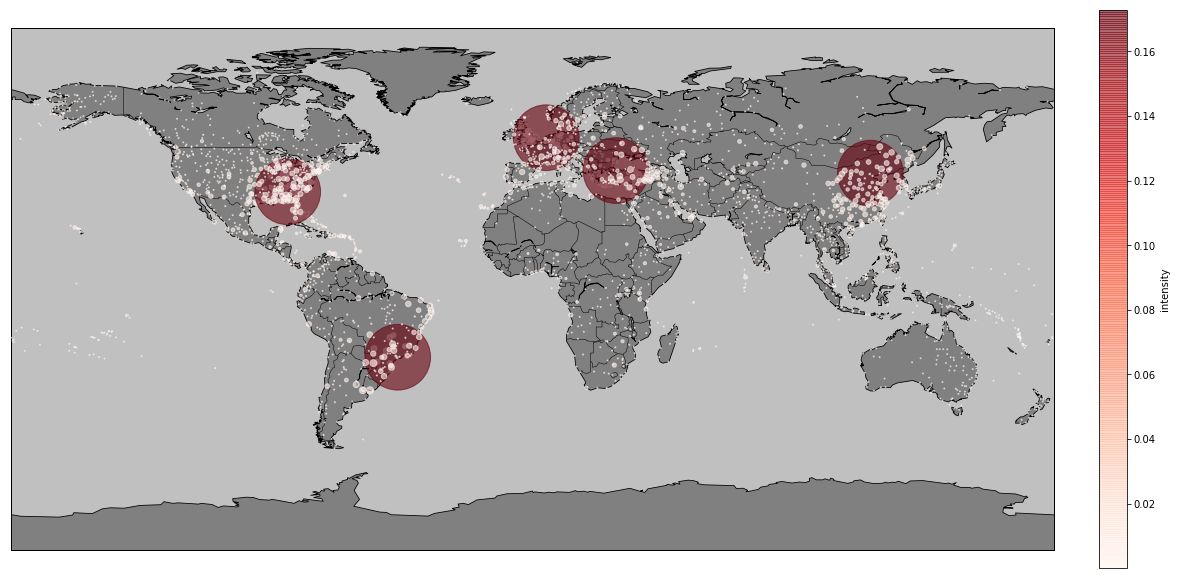

In [55]:
def find_k_sources_by_clustering(adj, airports_dict, k, kernel, **kwargs):
    """
    spectral clustering approach to find the best k sources efficiently
    
    the two steps are
     - clusters the network 'adj' in k groups
     - for each group, find the most efficient source 
     (efficiency of sources is measured on the whole network)
     
     The heat propagation model is used by default. Other propagation models
     can be specified with the 'kernel' parameter
    
    return two items:
    
    the list of indexes of k the best sources
    the source signal (on the whole graph) which equals 1/k for each source and 0 otherwise
    """

    clusters = spectral_clustering(adj, k, d=5)
    best_indexes = []
    
    # Looking for the best "infector" per cluster
    for label in range(k):
        indexes, = np.where(clusters == label)

        best_score = 0
        best_idx = -1
        for idx in indexes:

            # build a dirac 
            adj_idx = list(airports_dict.keys())[idx]    
            dirac = np.zeros(n_nodes_c)
            dirac[adj_idx] = 1
            
            # measure its propagation 
            filtered = graph_filter(dirac, kernel, **kwargs)
            score = metric_propag(filtered, threshold=1/n_nodes_c)
            
            # store the source that propagates the most
            if score > best_score:
                best_score = score
                best_idx = adj_idx
        best_indexes.append(best_idx)

    # Constructing the final signal, a "pseudo-dirac"
    best_dirac = np.zeros(n_nodes_c)
    for idx in best_indexes:
        best_dirac[idx] = 1/k
        
    return best_dirac, best_indexes
  
best_dirac, best_indexes = find_k_sources_by_clustering(adj_gt13, airports_gt13, 5, heat_kernel, t=t_heat)
kernel_map(best_dirac, scale_size= 25000, kernels="heat", metric_threshold=1/(n_nodes_c), legend="intensity",
          base_size=1, max_size=10000000)

According to our metric, this time we manage to infect 566 airports, which is slightly better than using the k most connected nodes. 

As we can see, the spectral clustering is a promising approach to find the best k sources for a given network, especially when k become large and greedy approaches are unfeasible in practice.


This algorithm could be applied to many other real-life problems. It is possible to use more sophisticated propagation models. 

Two intuitive examples are:
 - finding the best K mirrors to create an efficient network, 
 - finding the best production places to sell a product in a large area (maybe the entire world)'


In [56]:
# Printing the 5 winners
for i in best_indexes:
    print(features_c.set_index("Name", drop=True).iloc[i][["City", "Country", "IATA"]])
    print()

City       Istanbul
Country      Turkey
IATA            IST
Name: Atatürk International Airport, dtype: object

City         Amsterdam
Country    Netherlands
IATA               AMS
Name: Amsterdam Airport Schiphol, dtype: object

City             Atlanta
Country    United States
IATA                 ATL
Name: Hartsfield Jackson Atlanta International Airport, dtype: object

City       Beijing
Country      China
IATA           PEK
Name: Beijing Capital International Airport, dtype: object

City       Sao Paulo
Country       Brazil
IATA             GRU
Name: Guarulhos - Governador André Franco Montoro International Airport, dtype: object

